Our goal is to approach this problem from two sides: first - looking at the maximal flow we can achieve, and then finding the maximal heat transfer for that flow.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pint import UnitRegistry

import scipy as sp
from scipy import optimize as op

from fluid import Fluid

import json

I'll start by defining some basic helper functions

In [12]:
water = Fluid('water')

def Re(D, v, rho, mu):
    return rho*v*D/mu

def Nu(Re, Pr):
    if Re < 2300:
        return 3.66
    elif Re > 2300 and Re < 10000:
        return 4.36
    else:
        return 0.023*Re**(4/5)*Pr**(0.4)
    
def Nu_turbulent(Re, Pr):
    return 0.023*Re**(4/5)*Pr**(0.4)

def h(Nu, k, D):
    return Nu*k/D

def R_cond(k, A, t):
    return k*A/t

def R_conv(h, A):
    return 1/h*A

def u_avg(m_dot, rho, A):
    return m_dot/(rho*A)

def HydraulicDiameter(A, P):
    return 4*A/P

def T_o(Ti, m_dot, Cp):
    return (m_dot*Cp*Ti)/(m_dot*Cp)



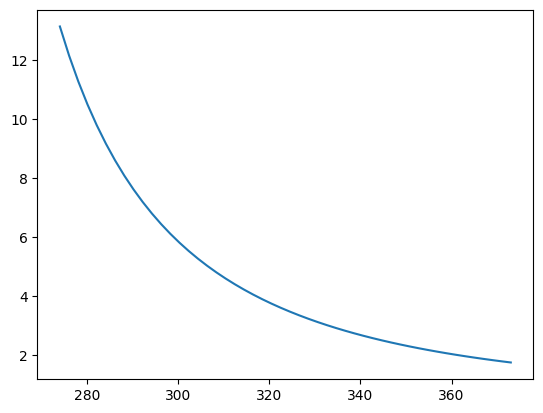

In [13]:
ts = np.linspace(274, 373, 50)
prs = np.zeros_like(ts)
for i,t in enumerate(ts):
    Pr = water.prandtl(P=101325, T=t)
    prs[i] = Pr
plt.plot(ts, prs)
plt.show()

In [35]:
# equation 1: energy balance on the top surface
def make_optimizer_egns(q_sun, T_inf, T_ci, h_air,
                        epsilon, sigma, k_module, k_water,
                        thickness, D, v, P=101325):
    Cp = lambda t: water.cpmass(P=P, T=t)
    module_conductivity = lambda Tl, Th : k_module  * (Th-Tl) / thickness
    m_dot_1d = lambda t: water.density(P=P, T=t) * v
    lmtd = lambda Tai, Tao, Tbi, Tbo: ((Tao-Tbo) - (Tai - Tbi))/(np.log(Tao-Tbo) - np.log(Tai-Tbi))
    he_Re = lambda t: Re(D, v, water.density(P=P, T=t), water.viscosity(P=P, T=t))
    he_Pr = lambda t:water.prandtl(P=P, T=t)
    he_Nu = lambda t: Nu_turbulent(he_Re(t), he_Pr(t))
    def equations(T):
        #print(f"Re: {he_Re(T_ci)}, Pr: {he_Pr(T_ci)}, Nu: {he_Nu(T_ci)}")
        T_h, T_l, T_co = T
        #print(T_h, T_l, T_ci, T_co)
        return [
            q_sun * (epsilon) - h_air*(T_h-T_inf) - epsilon * sigma * T_h**4 - module_conductivity(T_l, T_h), #todo add rho
            module_conductivity(T_l, T_h) - he_Nu(T_ci) * (k_water/ D) * lmtd(T_l, T_l, T_ci, T_co) , #todo check heat flux is correct
            module_conductivity(T_l, T_h) - m_dot_1d(T_ci) * Cp(T_ci) * (T_co-T_ci),
        ]
    return equations

    
    
    
a = 3.5e-3
b = 30e-3

param_dict = {
    "q_sun": 1e3, # W/m^2
    "T_inf": 300.15,
    "T_ci":285,#294.261, # https://edis.ifas.ufl.edu/publication/CH182,
    "h_air": 37.,
    "epsilon": 1,
    "sigma": 5.67e-8,
    "k_module": 1.72,
    "k_water": 0.6,
    "thickness": 3.5e-3, # m
    "D": 4 * (a*b)/(2*(a+b)), # hydraulic diameter of a rectangle
    "v": 1.219, # https://extension.usu.edu/irrigation/research/accurate-irrigation-water-flow-pipes
    "P": 413685.0,
    }

eqns = make_optimizer_egns(**param_dict)
T_l_init = 0.5 * (param_dict['T_inf'] + param_dict['T_ci'])
# use scipy to solve the system of equations
ts = op.least_squares(eqns,
                     [param_dict['T_inf'], T_l_init, 275],
                     bounds=([0, 0, 275],
                             [np.inf, np.inf, 373]))
# convert ts.x to a dictionary and put in celsius
T_h, T_l, T_co = ts.x #[t-273.15 for t in ts.x]
print(f"T_h: {T_h:.2f} C, T_l: {T_l:.2f} C, T_co: {T_co:.2f} C")

T_h: 285.16 C, T_l: 285.01 C, T_co: 285.00 C


/tmp/ipykernel_1231245/2345803603.py:8: RuntimeWarning: invalid value encountered in log
  lmtd = lambda Tai, Tao, Tbi, Tbo: ((Tao-Tbo) - (Tai - Tbi))/(np.log(Tao-Tbo) - np.log(Tai-Tbi))


In [6]:
param_dict['D']

0.00626865671641791